Загрузим и почистим данные

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("liver.csv")
df.duplicated().where(lambda x: x == True).dropna() ##  Явных дубликатов не найдено
df = df.dropna().reset_index()

### заккоментировал вывод строк, чтобы они не мешали отображению. Выводом воспользовался чтобы устранить неявные дубликаты
# for col in df.columns:
#     print(df[col].unique())

df["Gender"] = df["Gender"].replace("Mal","Male")
df["Gender"] = df["Gender"].replace(["Male","Female"],[0,1])
df["Dataset123"] = df["Dataset123"].replace(["yes","no"],["1","2"])
df["Dataset123"] = df["Dataset123"].replace(["1","2"],["1","0"])
df["Aspartate_Aminotransferase"] = df["Aspartate_Aminotransferase"].replace("3a4","34")
df = df.rename(columns={"Dataset123":"IsSick"})
df = df.astype({
    'Gender':'int64',
    "IsSick":"int64",
    "Alkaline_Phosphotase":"int64",
    "Aspartate_Aminotransferase":"int64"})
df.head()


,index,Age,Gender,TotalBilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,IsSick
0,0,65,1,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,1,62,0,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,2,62,0,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,3,58,0,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,4,72,0,3.9,2.0,195,27,59,7.3,2.4,0.40,1


Cтандартизируем данные c помощью объекта StandardScaler из модуля sklearn.preprocessing. Удалим целевой показатель из датафрейма.

In [3]:
IsSick = list(df.pop('IsSick'))
index = list(df.pop('index'))
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
sc.fit(df)
df_sc = sc.fit_transform(df)

Теперь из стандартизированных данных построим дендрограмму и определим оптимальное количество  кластеров для кластеризации с помощью KMeans

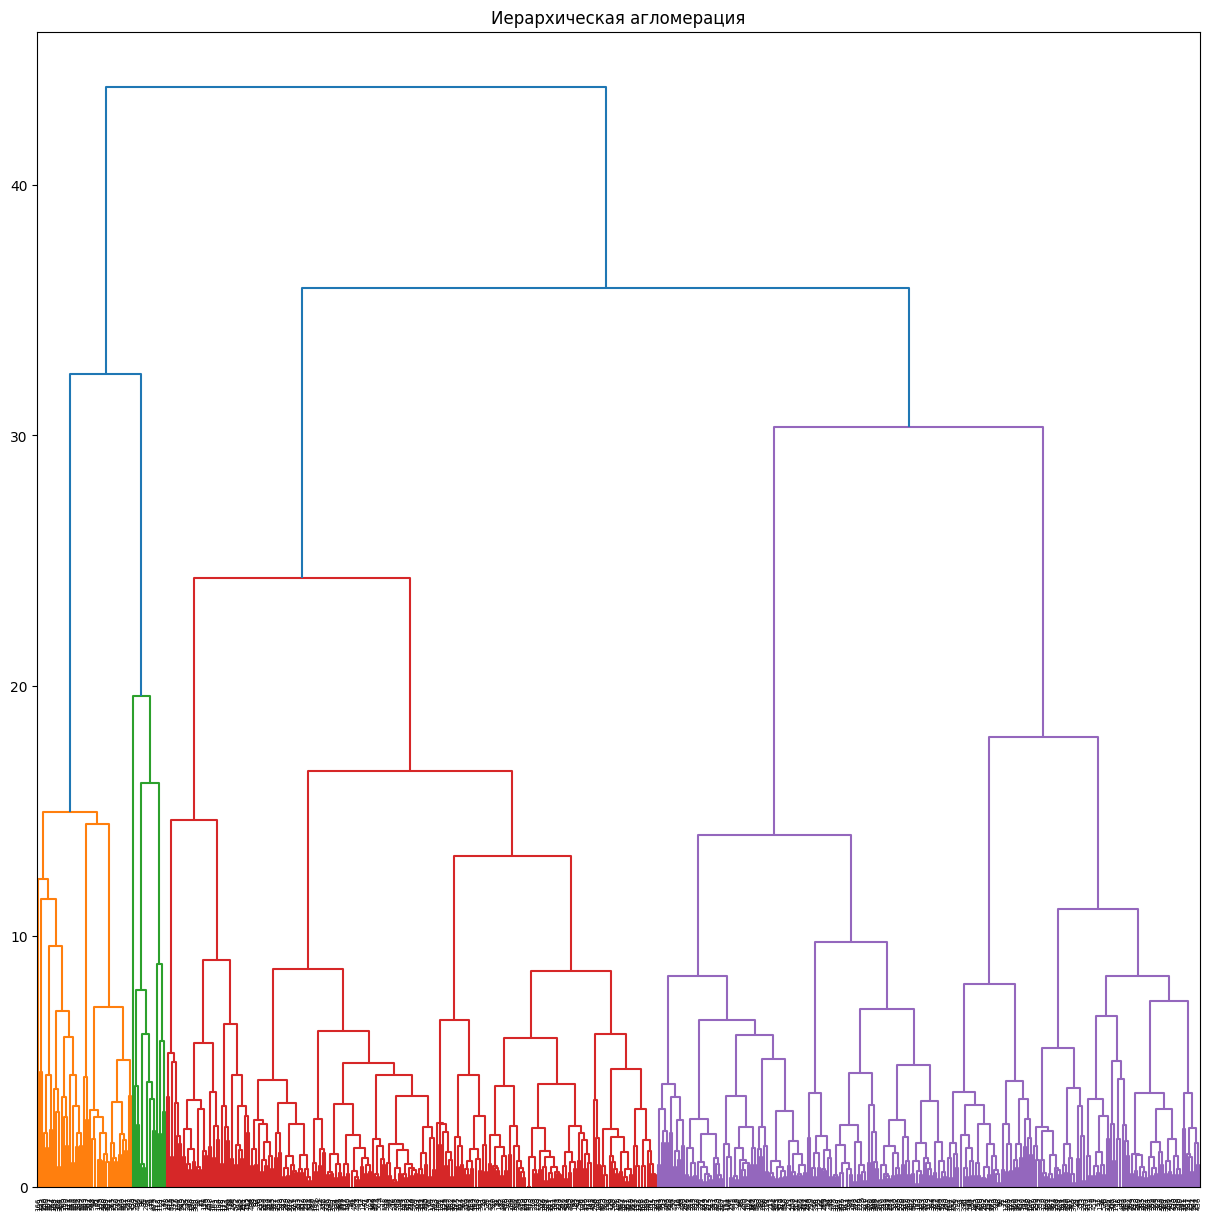

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(df_sc,method='ward', metric="euclidean")
plt.figure(figsize=(15,15))
dendrogram(linked,orientation='top')
plt.title('Иерархическая агломерация')
plt.show()


Предложенное оптимальное количество 4 (исходя из количества цветов кластеров)
Однако я считаю, что в целях нашей предметной области кластеров должно быть 2 (Больные и здоровые)

Оценим по каким показателям проводились кластеризация(какие показатели повлияли на нее больше всего)

In [5]:
from scipy.cluster.hierarchy import fcluster
df["cluster"] = fcluster(linked,4,criterion="maxclust")
df.groupby("cluster").mean()

,Age,Gender,TotalBilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
cluster,,,,,,,,,,
1,42.148936,0.148936,19.631915,9.308511,364.063830,115.829787,200.808511,6.510638,2.644681,0.793191
2,40.764706,0.058824,6.958824,3.252941,306.470588,919.294118,1267.941176,5.929412,2.805882,0.892353
3,51.122449,0.024490,2.215918,0.982041,339.918367,49.910204,67.575510,5.960816,2.690612,0.815184
4,39.756458,0.464945,1.230258,0.481181,231.682657,50.523985,60.354244,6.980812,3.660148,1.102509


Из таблицы видно, что наибольшая дельта (в процентах) среди строк заметна у общего и прямого билирубина  , Аламинааминотрансферазы и и аспартатоаминотрансферазы. Общие количество белков и альбуминов а также их соотношение во всех кластерах примерно одинаковое, за исключением четвертого кластера, в которыъ эти значения повышены, а щелочная фосфотаза в нем понижена. 

С помощью алгоритма к-средних попробуем кластеризовать наш датафрейм на 2 кластера - Больных и здоровых

In [6]:
from sklearn.cluster import KMeans
kmens = KMeans(n_clusters=2,random_state=0)
kmens.fit(df_sc)

df["cluster"] = kmens.labels_
df.groupby("cluster").mean()

C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Age,Gender,TotalBilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
cluster,,,,,,,,,,
0,45.536232,0.159420,15.640580,7.279710,537.826087,315.565217,458.376812,6.286957,2.610145,0.740725
1,44.679061,0.252446,1.640117,0.707436,256.902153,49.350294,63.164384,6.507241,3.215264,0.978160


Здесь мы видим, что основными показателями для кластеров стали билирубин, щелочная фосфатаза, аламинаминотрансфераза и аспартатаминотрансфераза

Выполним также расчет евликодова расстояния между кластерами.

In [7]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(df)

array([[  0.        , 520.88072109, 310.34593617, ...,  40.42214739,
         95.27696469,  95.27696469],
       [520.88072109,   0.        , 211.51170771, ..., 491.54664845,
        606.15643987, 606.15643987],
       [310.34593617, 211.51170771,   0.        , ..., 281.36240349,
        395.22644661, 395.22644661],
       ...,
       [ 40.42214739, 491.54664845, 281.36240349, ...,   0.        ,
        119.06506625, 119.06506625],
       [ 95.27696469, 606.15643987, 395.22644661, ..., 119.06506625,
          0.        ,   0.        ],
       [ 95.27696469, 606.15643987, 395.22644661, ..., 119.06506625,
          0.        ,   0.        ]])

Рассмотрим к каким кластером относится каждый объект(кажадя строка в csv файле)

In [8]:
kmens.labels_

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Также с помощью elbow метода определим оптимальное число кластеров. По агломерационному методу оптимальным числом было 4.

C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Егор\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\User

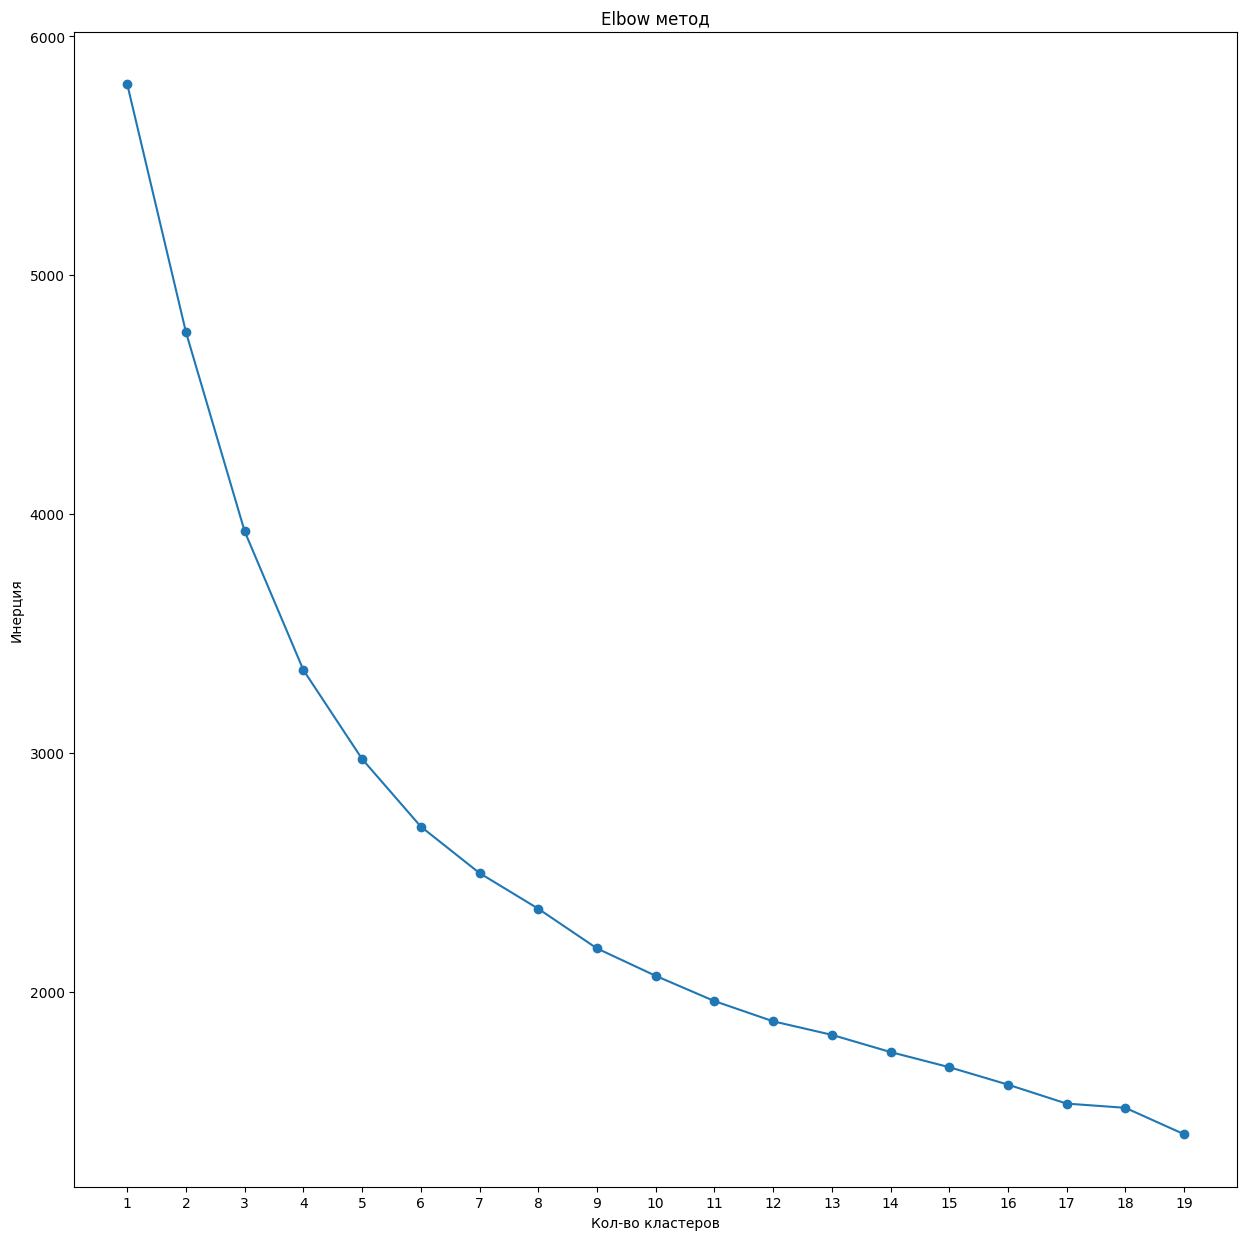

In [16]:
models  = [KMeans(n_clusters=i, random_state=0).fit(df_sc) for i in range(1,20)]
dist = [model.inertia_ for model in models]
fig = plt.figure(figsize=(15,15))
plt.plot(range(1,20),dist,marker="o")
plt.xticks(range(1,20),range(1,20))
plt.xlabel("Кол-во кластеров")
plt.ylabel("Инерция")
plt.title("Elbow метод")
plt.show()

Изходя из графика можно заметить, что после 4 кластеров уменьшение инерции происходит менее активно. Это говорит о том, что оптимальное количество кластеров равно 4, хотя и 5 кластеров не самый плохой вариант.